# 全結合のNNで層を深く（ディープに）することの意味

畳み込みではない、層間が全結合の順伝播型ニューラルネットワークにおいて、層を深く（ディープに）することには、どんな意味があるのでしょう。

何周遅れの話なんだという感じですが、自分でネットワークを実装してみて腹落ちしたような気がするので、投稿します。

## ニューラルネットワークの動機

そもそも、コンピュータプログラムは、入力xを受け取り、出力yを返す関数fとして理解できます。なお、数学的な意味での関数と異なるのは、入出力等の副作用（side effect）を伴うところです。

![入出力](figures/meaning-of-deeper-network-0000.jpg)

プログラマは、小さな関数を重ね合わせたり（関数型言語）、手続きを並べたり（手続き型言語）、オブジェクト同士でメッセージのやり取りをしたり（オブジェクト指向言語）して、関数fを実装します。

ところが、何らかの理由で、関数fを直接書き下せないことがあります。一例を挙げれば、囲碁の局面を評価する評価関数。囲碁は、自然言語では「このへんの白は模様が良い」「黒の右辺には厚みがある」などと語られますが、これを明示的にプログラミングするのは非常に難しい。

ここに、関数fを**直接書き下すのでなく、何らかの手段で近似したい**、という動機が生まれるわけです。これがニューラルネットワークを生み出した動機だと、私は思っています。——歴史を調べたわけではないので、間違っているかもしれませんが…。

## ユニットの組み合わせ

さて、ニューラルネットワークでは、簡単な関数（**活性化関数**）からなる**ユニット**を複数組み合わせることで、複雑な関数を近似します。

活性化関数には、例えば、**シグモイド関数**というものがあります。以下にシグモイド関数を描画します。（最初は主流のReLUでやってみたけど、あまり面白くなかったので、シグモイドでいきます。）

In [1]:
import numpy as np
import matplotlib.pyplot as plt


def visualize(xs, ys):
    plt.figure()
    plt.plot(xs, ys, marker='.')
    plt.grid()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()


class B:
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    def identity(x):
        return x

    @classmethod
    def rand(cls, np_random):
        return np_random.rand() * 10 - 5

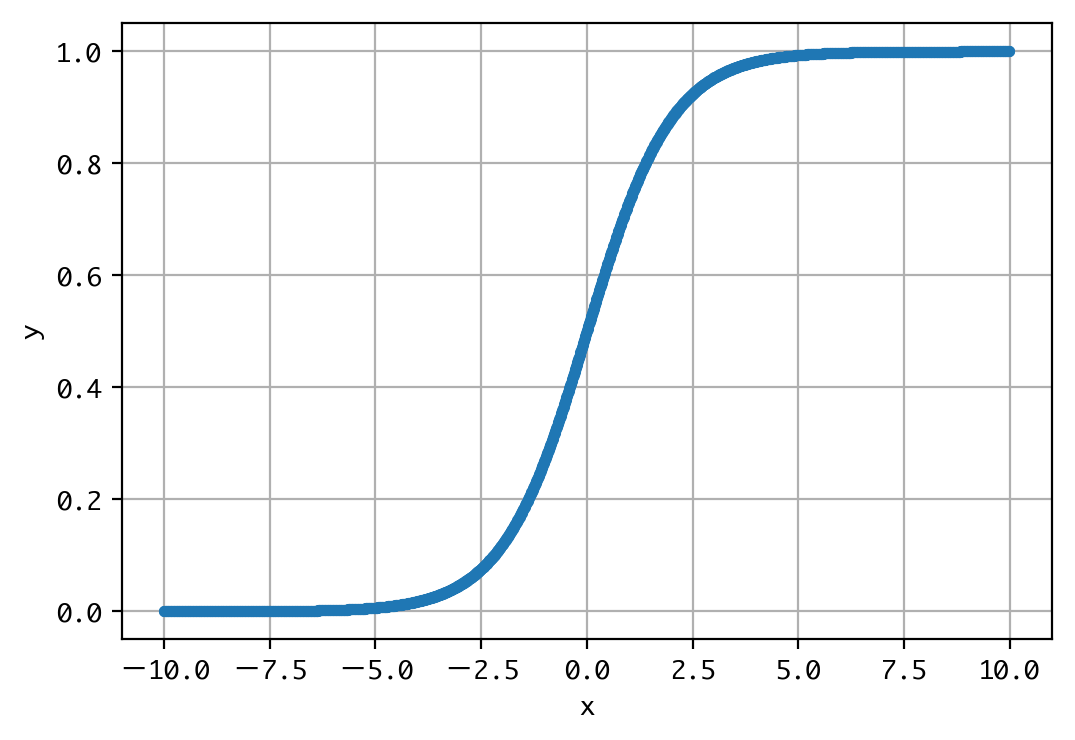

In [2]:
x = np.arange(-10, 10, 0.01)
y = B.sigmoid(x)
visualize(x, y)

シグモイド関数は、ただこれだけの素片ですが、入力のxに重みとバイアスを加味することで、様々に変形します。以下に変形例を二点描画します。

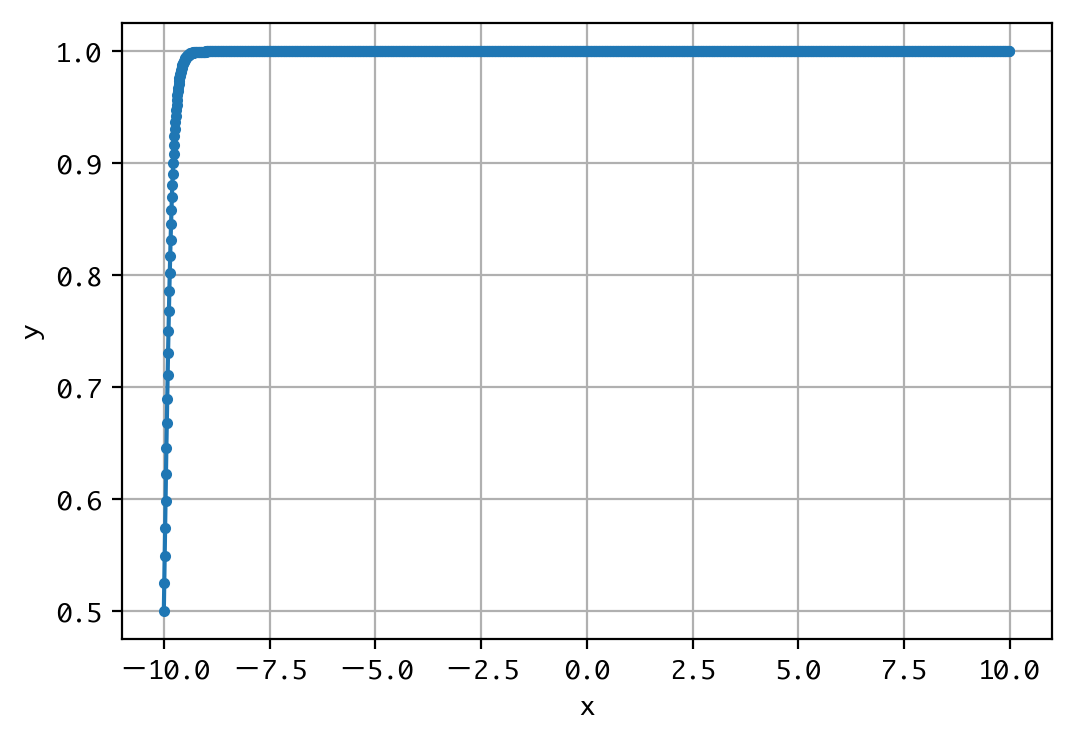

In [3]:
x = np.arange(-10, 10, 0.01)
y = B.sigmoid(10 * x + 100)
visualize(x, y)

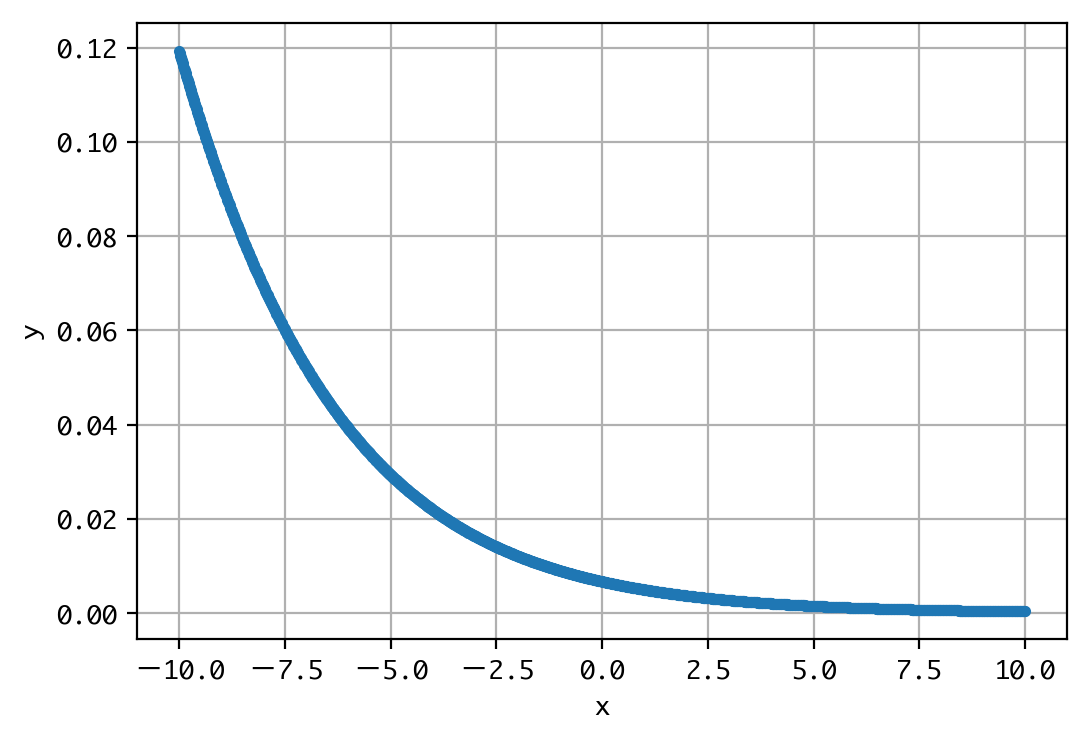

In [4]:
x = np.arange(-10, 10, 0.01)
y = B.sigmoid(-0.3 * x - 5)
visualize(x, y)

こうした、シンプルながらも表情豊かな曲線を合成することで、より複雑な曲線を近似できる、というのがニューラルネットワークの基本思想だと私は理解しています。

## ネットワークの作成

さて、ネットワークと呼ぶくらいなので、ユニットを縦横無尽に組み合わせます。

以下に、**全結合層**からなるネットワークの例を図示します。矢印が密集（Dense）しているのが、なんだか気持ち悪いですね。

![全結合ネットワーク](figures/meaning-of-deeper-network-0001.jpg)

この、（中間層ごとの）ユニット数、中間層の数、共に3のネットワークを作成してみることにしましょう。重みやバイアスは適当に（シード固定の乱数を使って）設定することにします。

まずは、色々と条件を変えて実験できるように、汎用的な形で全結合層とネットワークのクラスを書きます。入力Xはベクトルを想定しているので、行列の演算が出てきますが、難しいものではないかと思います。

In [5]:
class Dense:
    def __init__(self, n, input_dim, activation, np_random):
        self.n = n
        self.input_dim = input_dim
        self.activation = activation
        self.np_random = np_random
        
        # 重みは、input_dim * n の行列となる
        weights = [[B.rand(np_random) for _ in range(self.n)] for _ in range(self.input_dim)]
        self.weights = np.array(weights)
        
        # バイアスは、1 * n のベクトルとなる
        self.bias = np.array([B.rand(np_random) for _ in range(self.n)])
    
    def forward(self, X):
        assert X.size == self.input_dim
        
        # 入力X（1 * input_dim のベクトル）に重みをかけて、バイアスを足す
        self.forwarded = self.activation(np.dot(X, self.weights) + self.bias)
        return self.forwarded.copy()


class Network:
    def __init__(self, np_random):
        self.layers = []
        self.np_random = np_random
        
    def add(self, n, input_dim=2, activation=None):
        _input_dim = input_dim
        if len(self.layers) > 0:
            _input_dim = self.layers[-1].n
        
        if activation is None:
            _activation = B.identity
        elif activation == 'sigmoid':
            _activation = B.sigmoid
        elif activation == 'identity':
            _activation = B.identity
        else:
            raise ValueError('Unknown activation: {}'.format(activation))
        
        self.layers.append(Dense(n, _input_dim, _activation, np_random))
    
    def forward(self, X):
        self.forwarded = X
        for layer in self.layers:
            self.forwarded = layer.forward(self.forwarded)
        return self.forwarded.copy()


xs = [np.array([x]) for x in np.arange(-5, 5, 0.01)]

さて、適当なネットワークを作成し、身長と体重風の数値（私のではない）を通してみましょう。

In [6]:
np_random = np.random.RandomState(0)
n = Network(np_random)
n.add(3, input_dim=2, activation='sigmoid')
n.add(3, activation='sigmoid')
n.add(1)

x = np.array([165, 52])
y = n.forward(x)

print(y)

[-1.02875705]


なんぞ、よくわからん数値が出てきました。とりあえず、動いているようです。[こいつ・・・動くぞ！](http://dic.nicovideo.jp/a/%E3%81%93%E3%81%84%E3%81%A4%E3%83%BB%E3%83%BB%E3%83%BB%E5%8B%95%E3%81%8F%E3%81%9E%21)

それでは、ユニット数、中間層の数、共に3のネットワークを作成してみましょう。

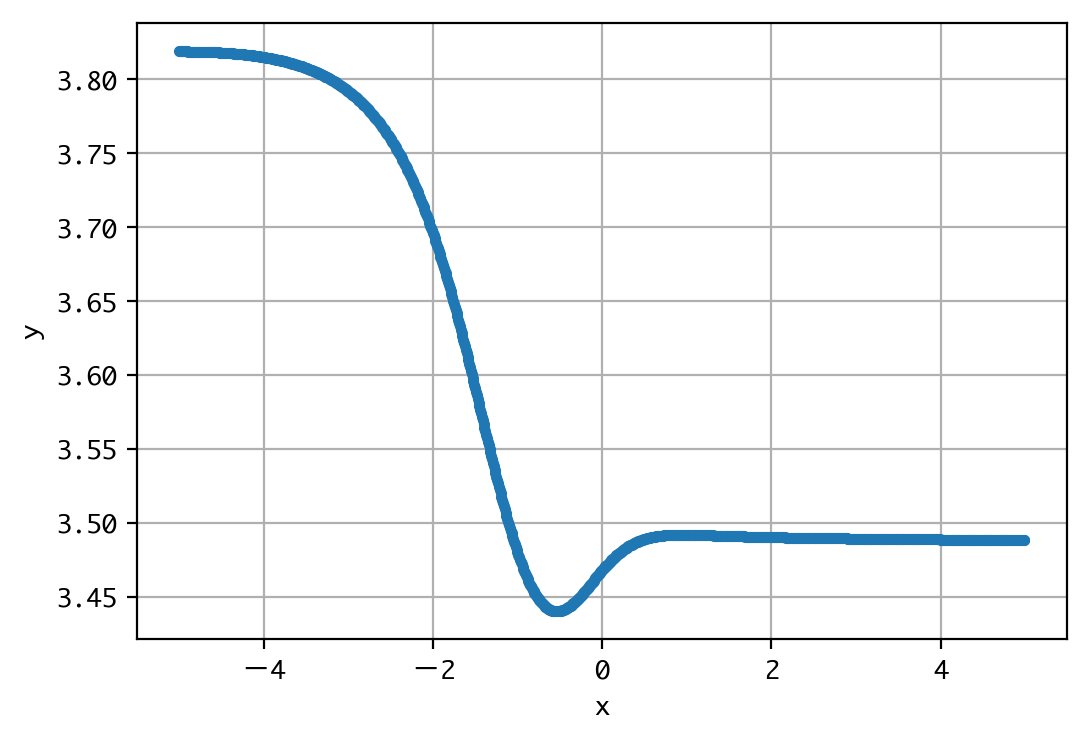

In [7]:
# 実験0
np_random = np.random.RandomState(0)
n0 = Network(np_random)
n0.add(input_dim=1, n=3, activation='sigmoid')   # 入力層
n0.add(input_dim=3, n=3, activation='sigmoid')   # 中間層1
n0.add(input_dim=3, n=3, activation='sigmoid')   # 中間層2
n0.add(input_dim=3, n=3, activation='sigmoid')   # 中間層3
n0.add(input_dim=3, n=1, activation='identity')  # 出力層
ys0 = [n0.forward(x) for x in xs]
visualize(xs, ys0)

うん。元のシグモイド関数の面影は消えましたね。

このように、ユニットを組み合わせてネットワークを作成することで、任意の関数を近似（表現）できそうな気がします。あくまで気分ですけどね。

## 本題：ネットワーク対決

さて、かねがね疑問に思っていたのですが、１）中間層が1つしかないがユニット数の多いネットワークと、２）ユニット数は少なめだが中間層の多い——よりディープな——ネットワークでは、どちらが表現力に富むのでしょうか。

以下、対決させてみたいと思います。総ユニット数（シグモイド関数の適用回数）は256で固定します。重みやバイアスを変えつつ、グラフを10個ずつ描画します。

### １）中間層が1つしかないがユニット数の多いネットワーク

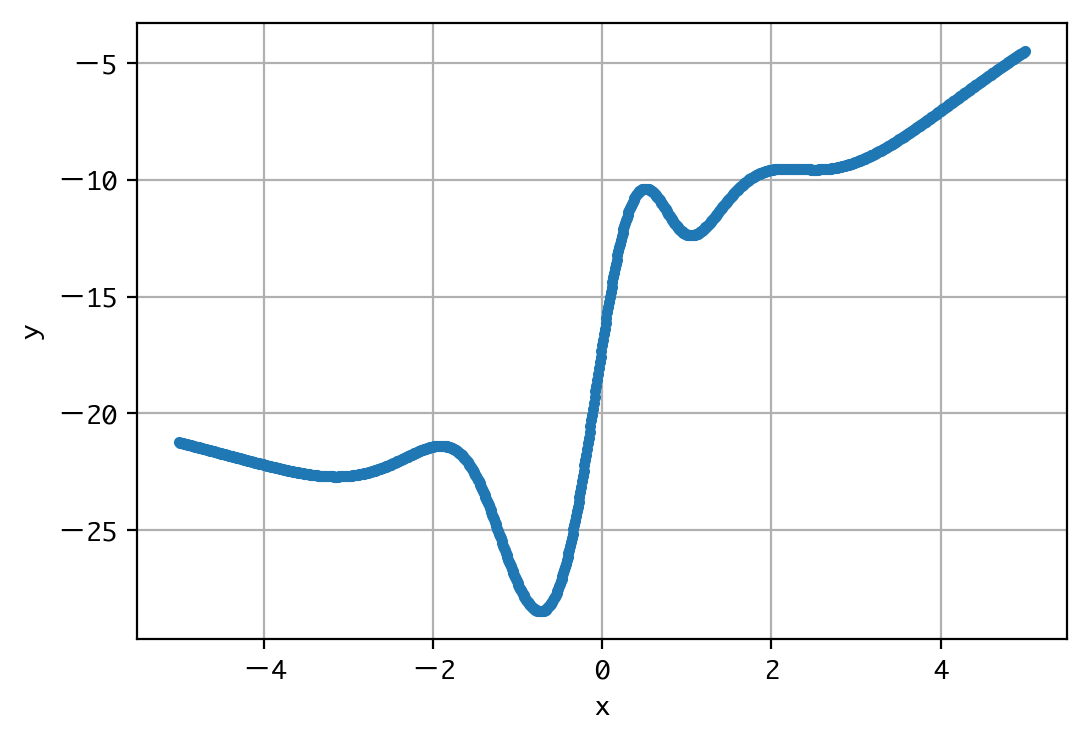

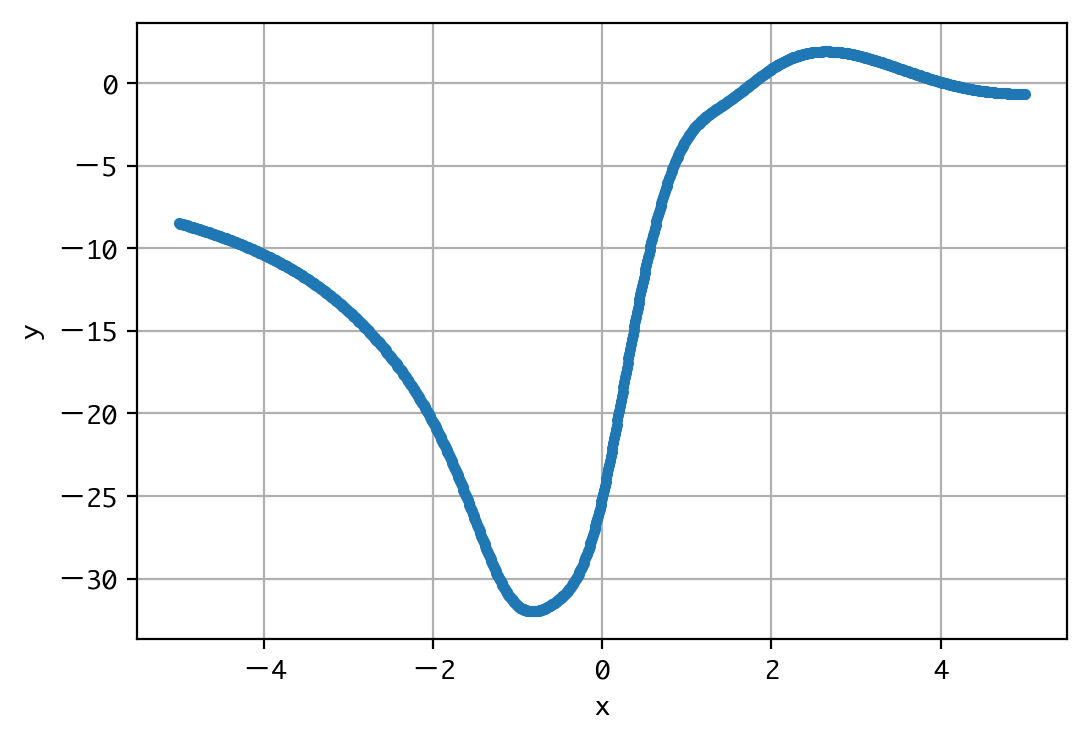

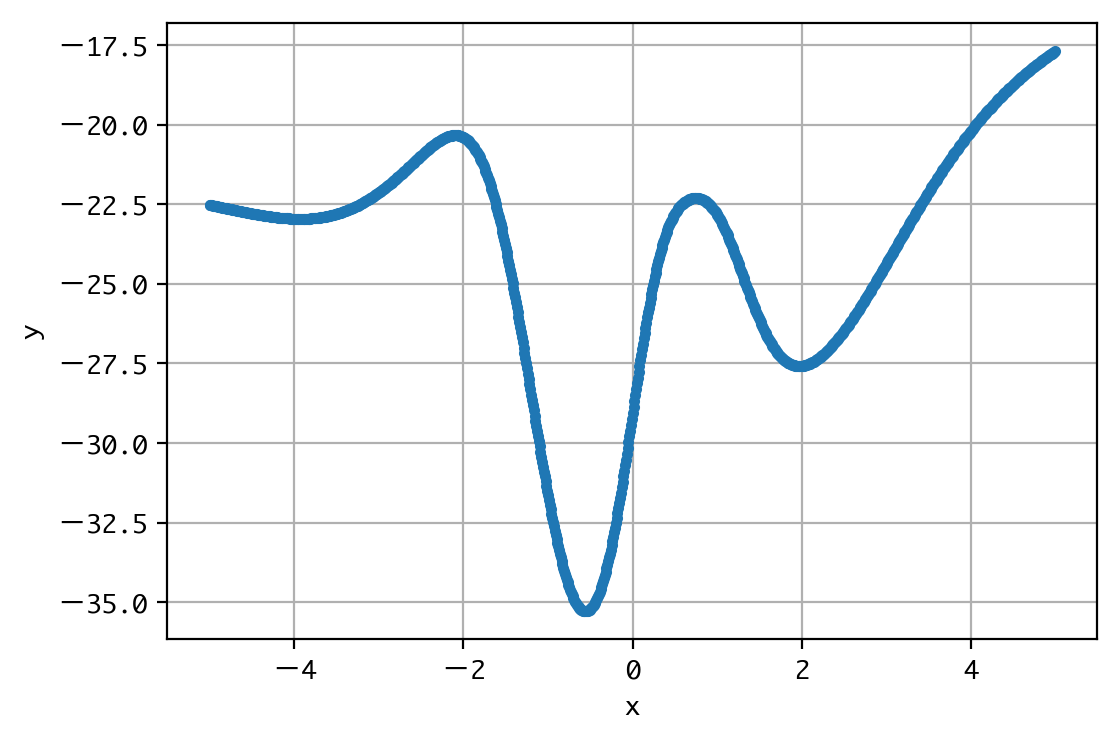

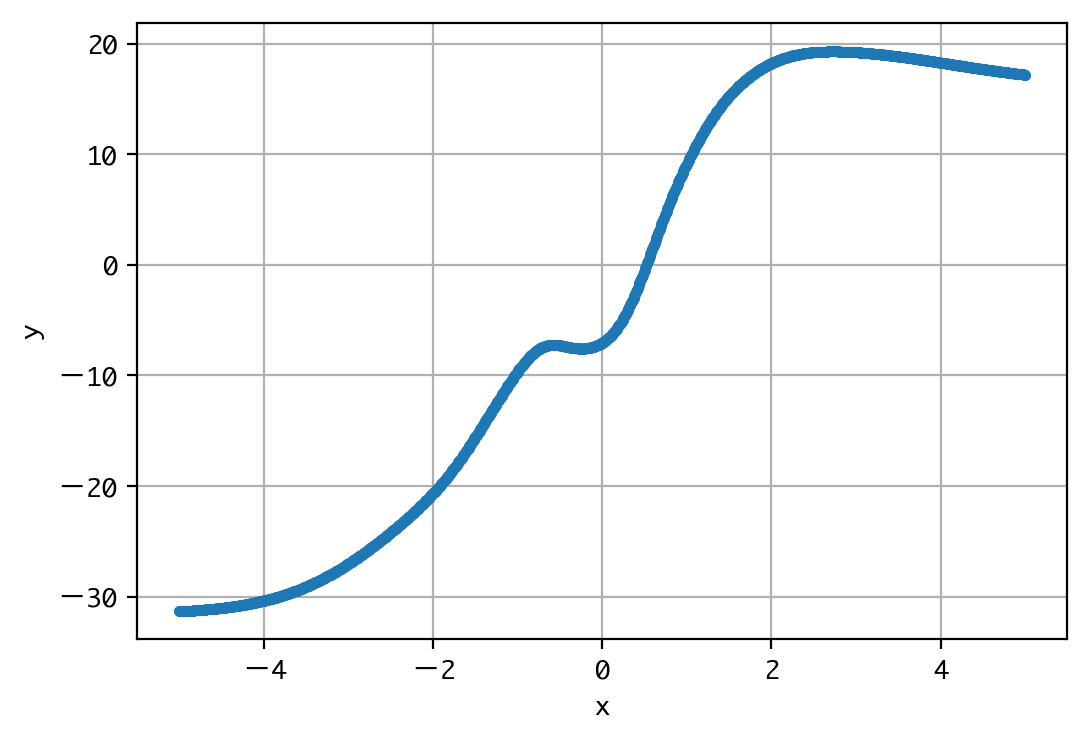

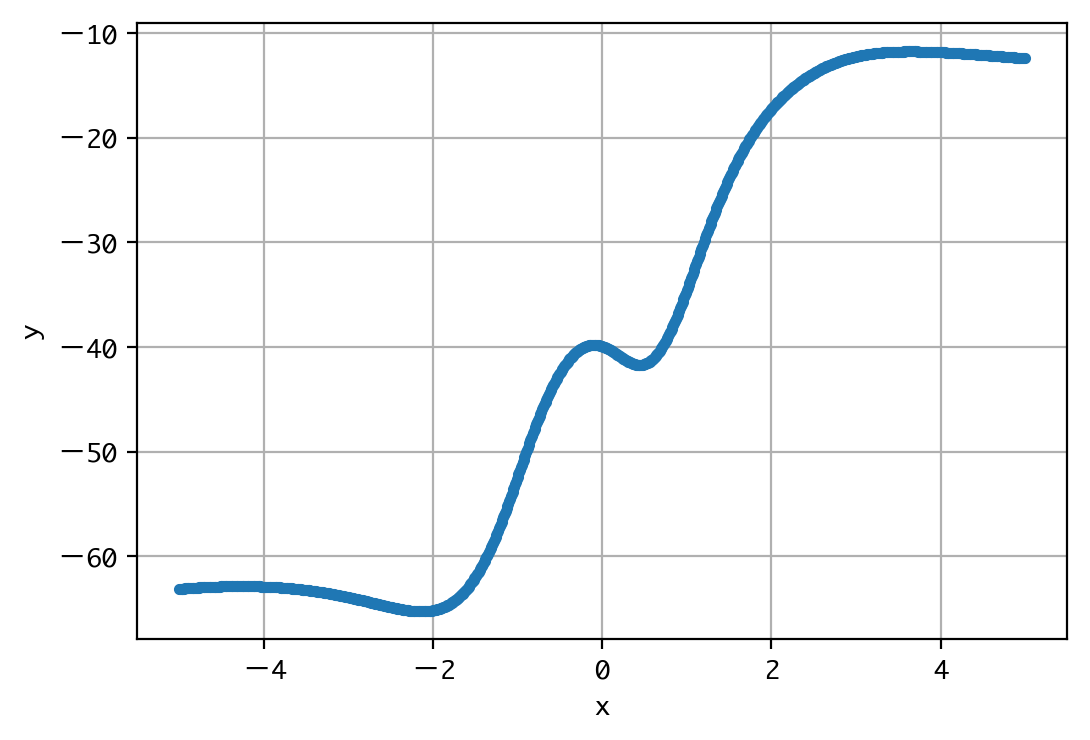

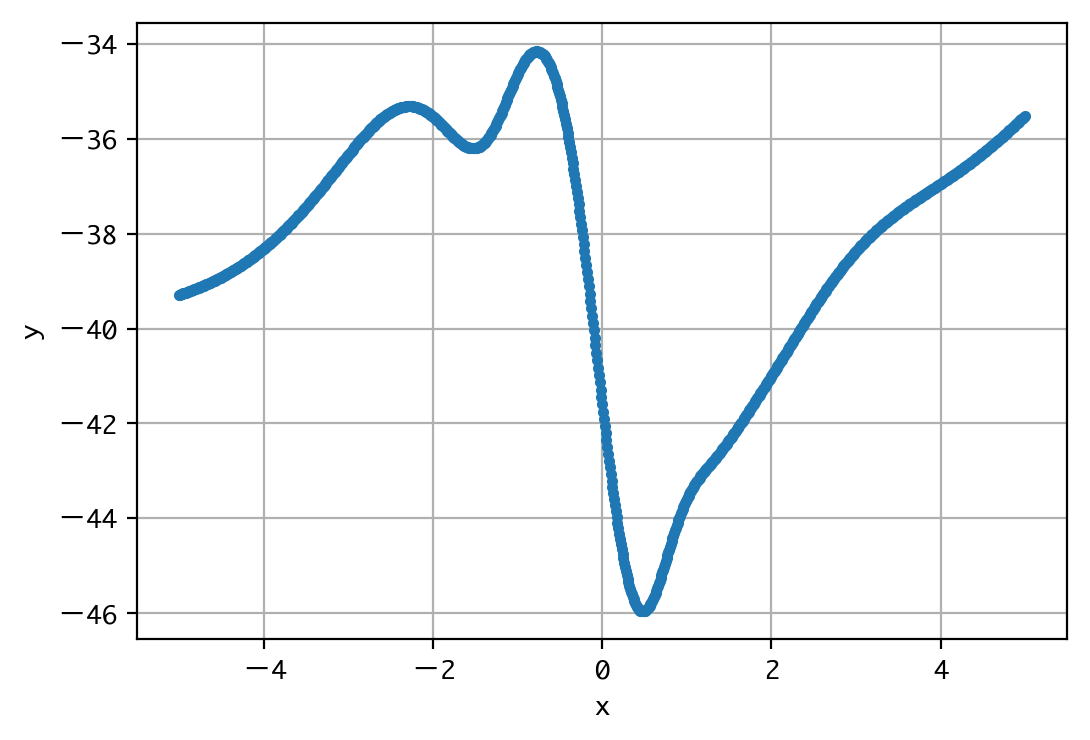

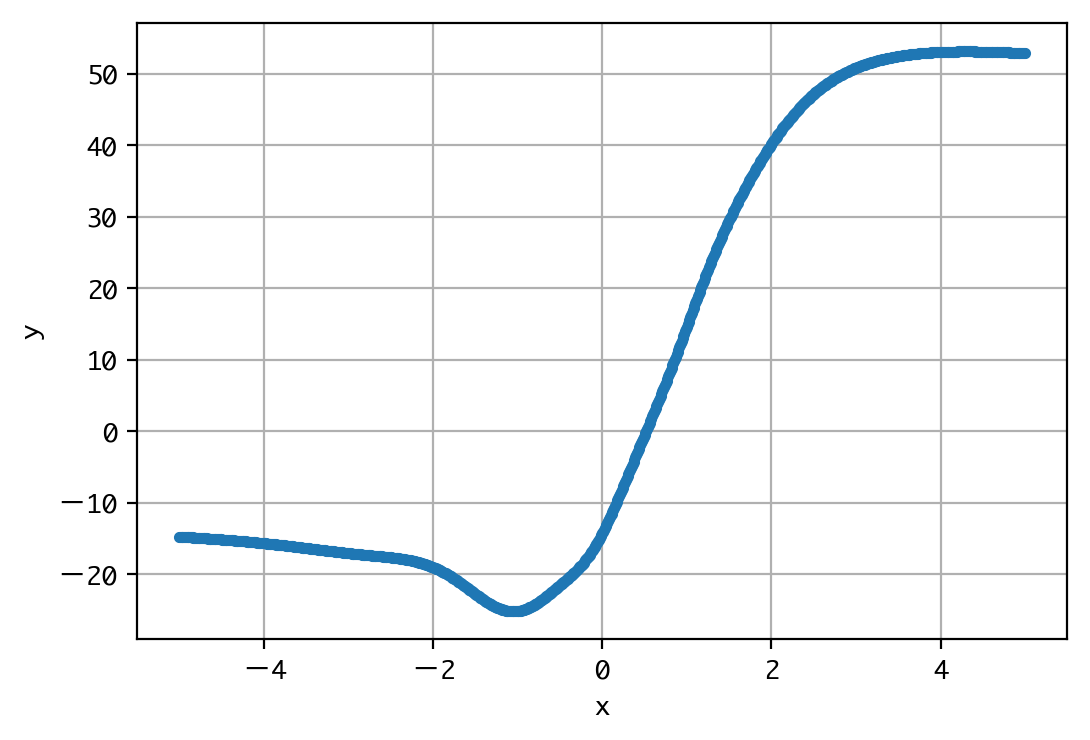

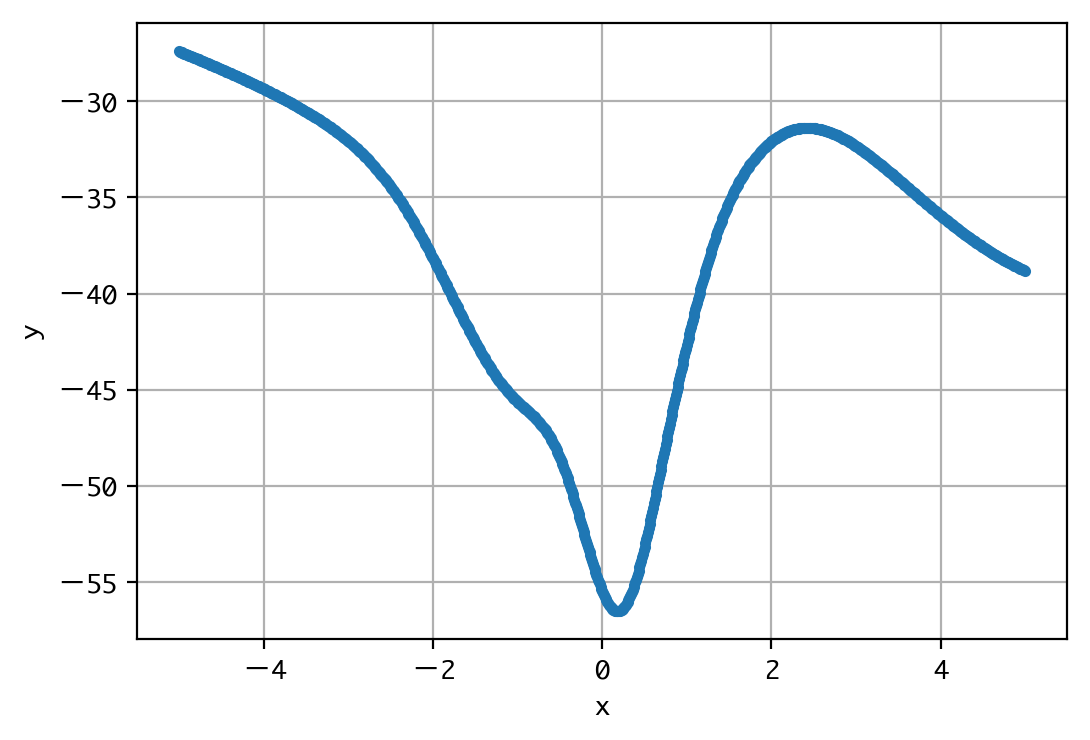

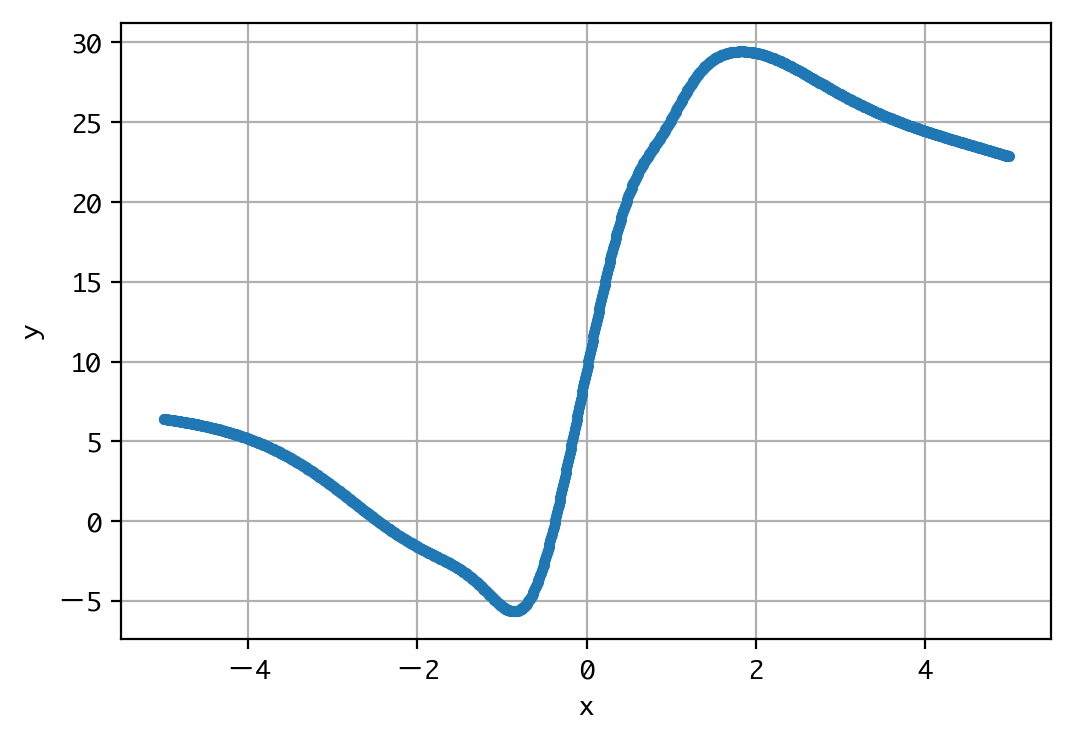

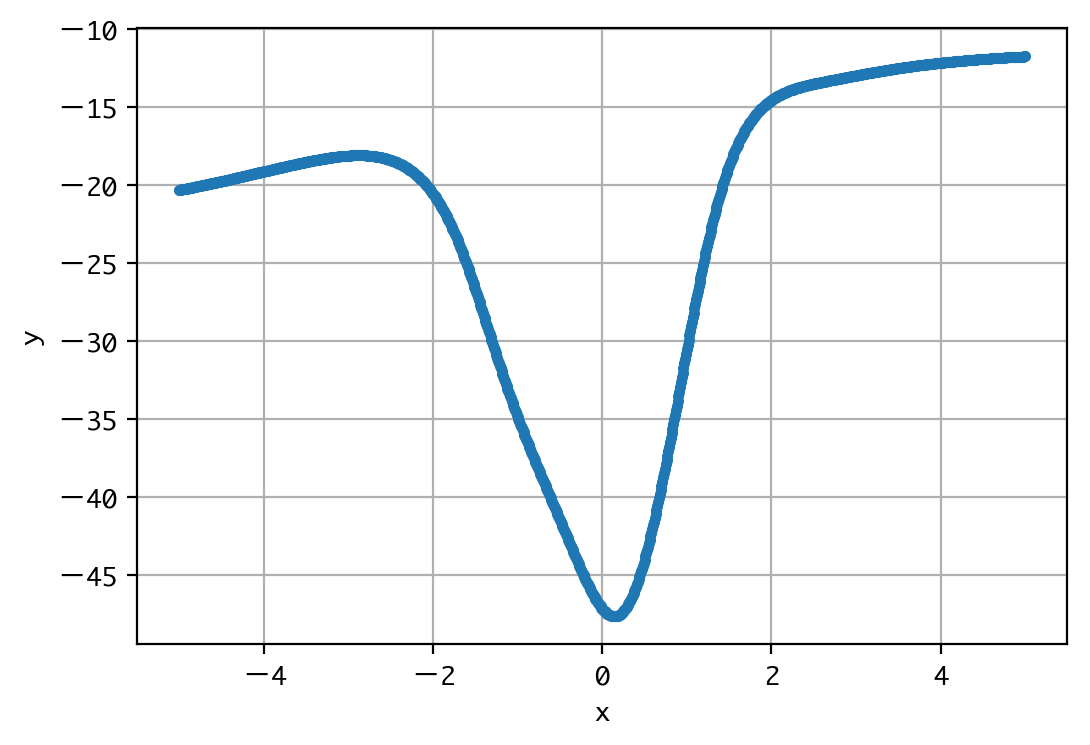

In [8]:
# 実験1
for seed in range(10):
    np_random = np.random.RandomState(seed)
    n1 = Network(np_random)
    n1.add(256, input_dim=1, activation='sigmoid')
    n1.add(1)
    ys1 = [n1.forward(x) for x in xs]
    visualize(xs, ys1)

ウネウネしたグラフが10個描画できました。

### ２）ユニット数は少なめだが中間層の多いネットワーク

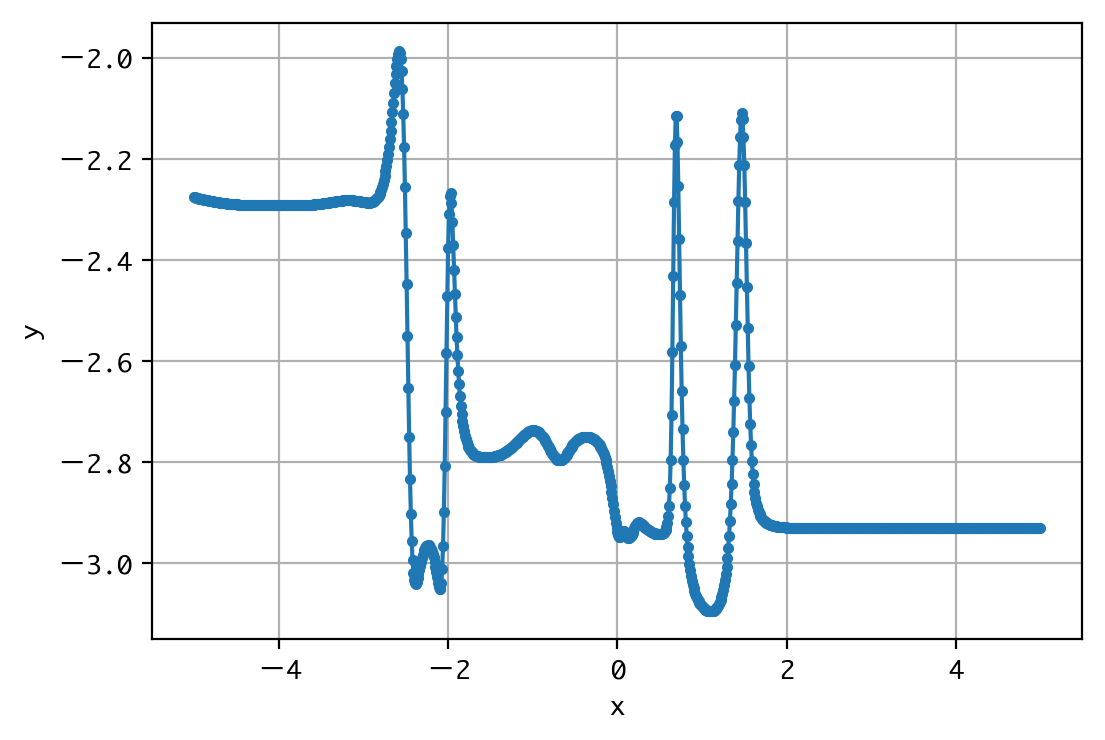

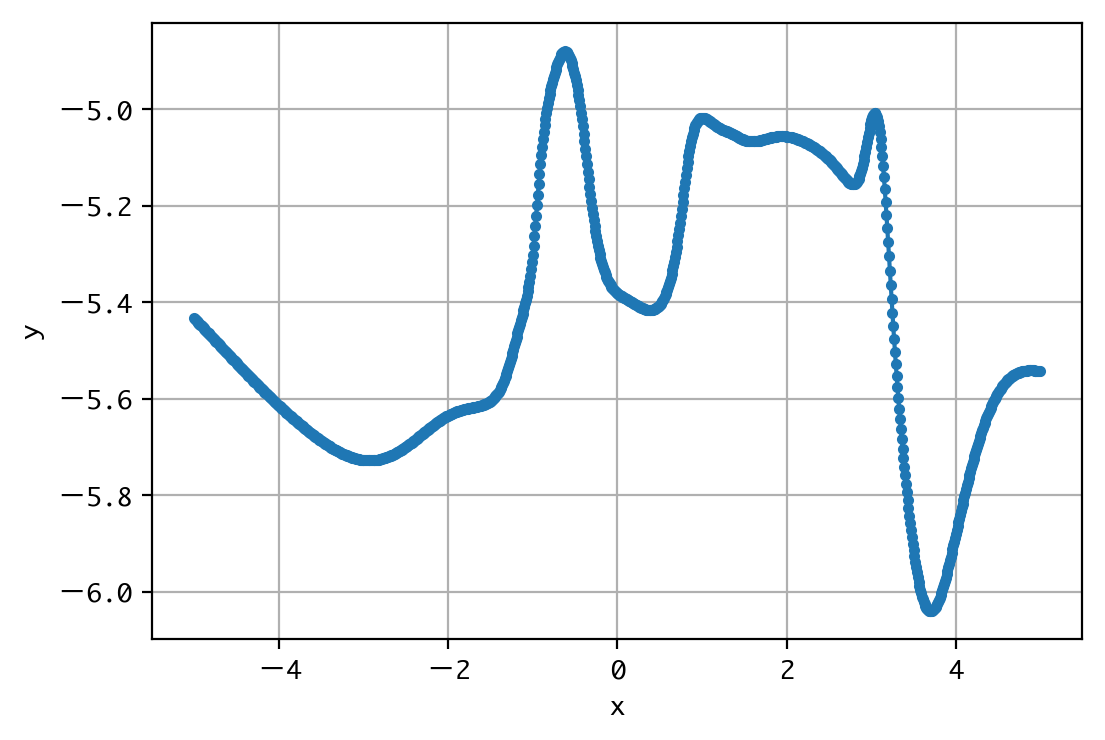

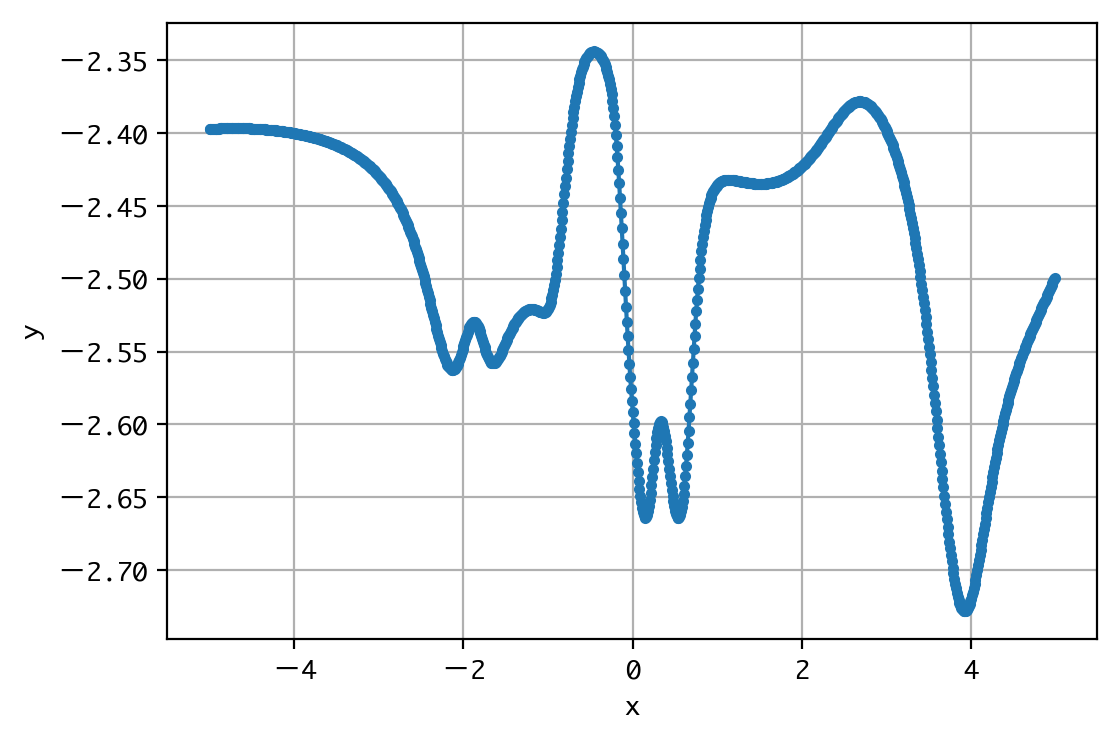

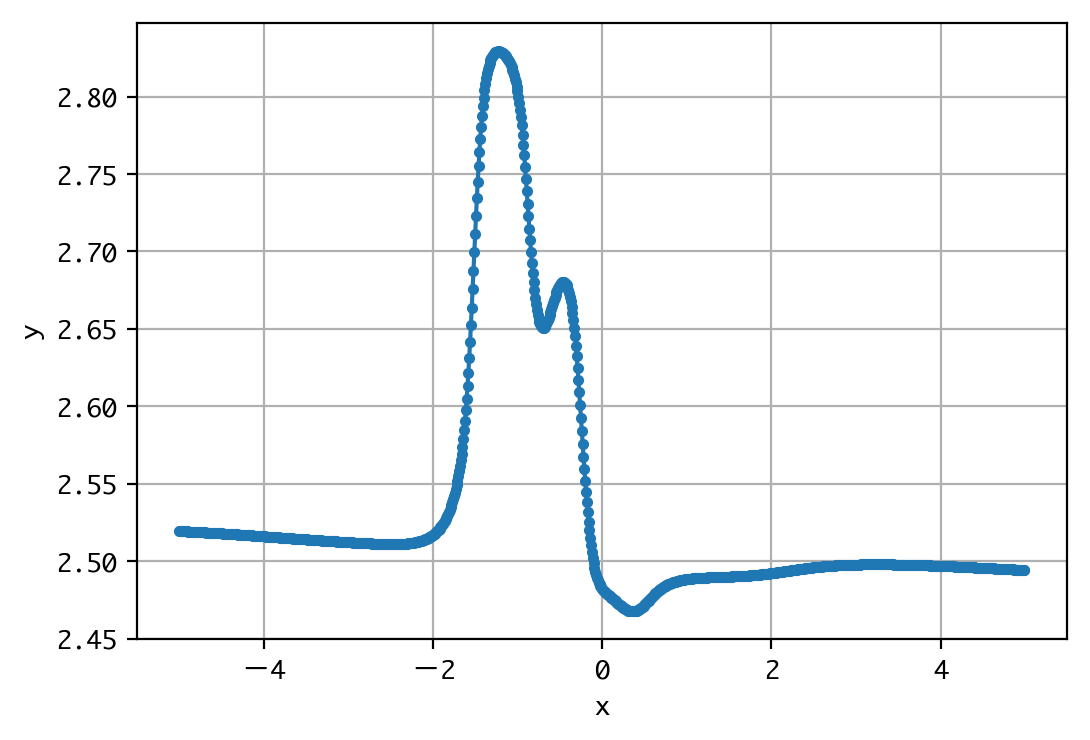

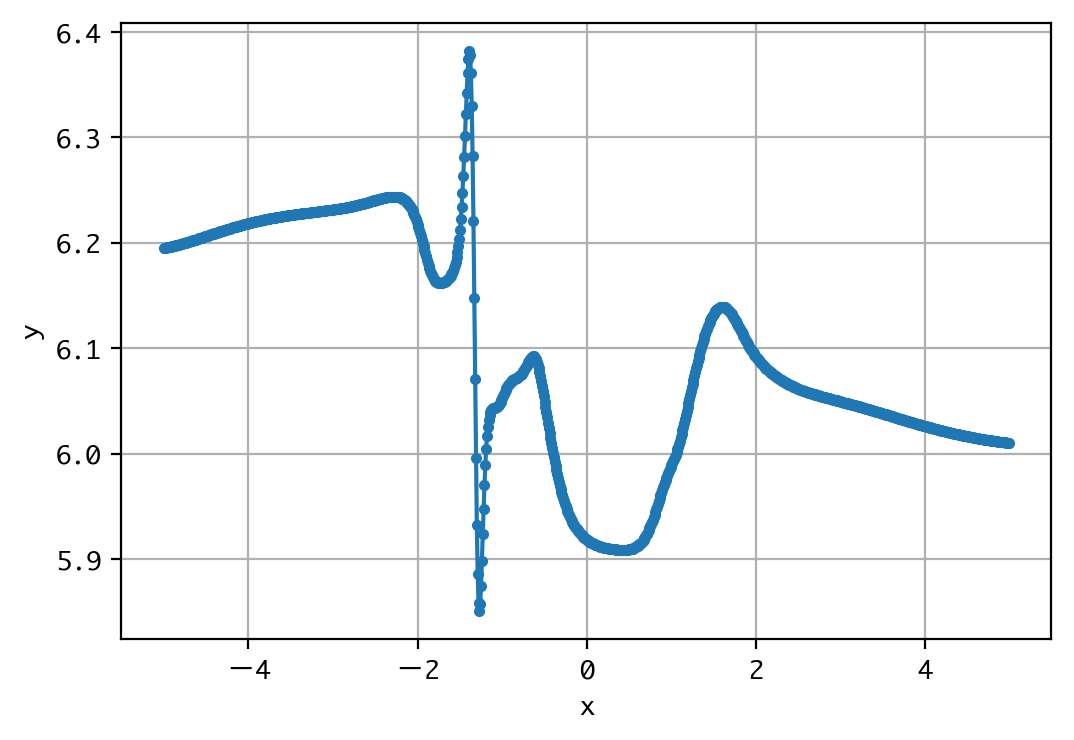

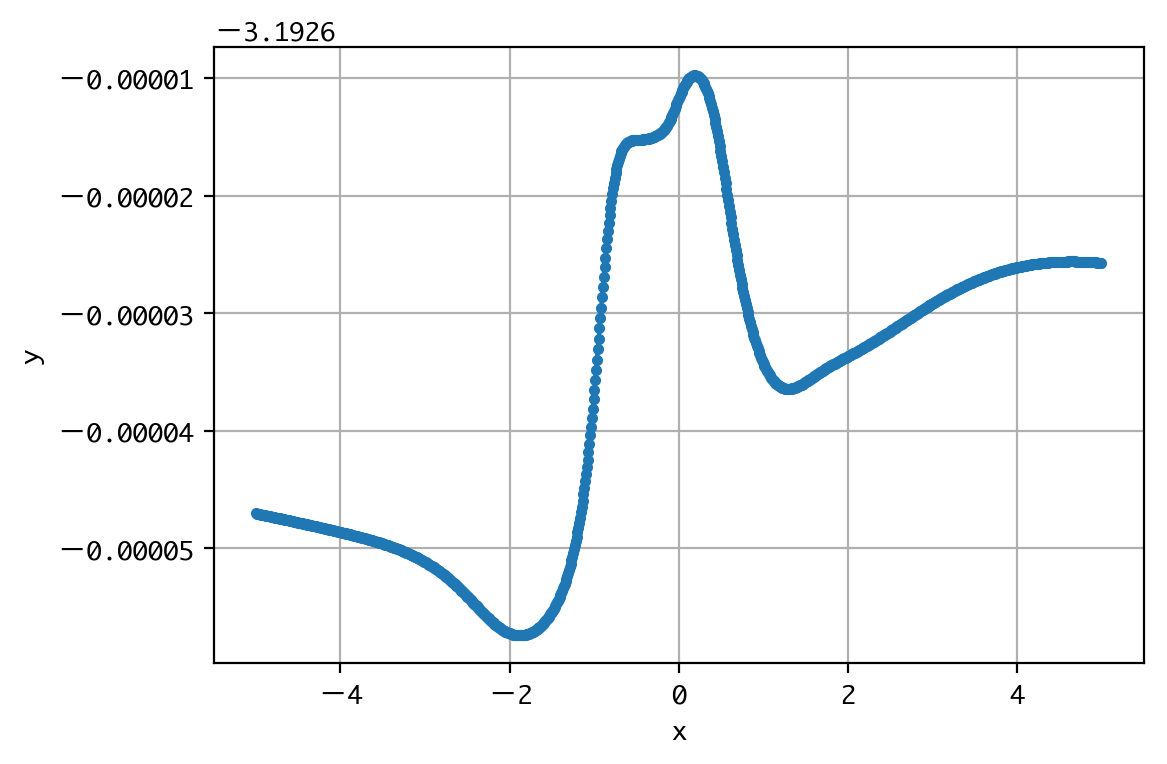

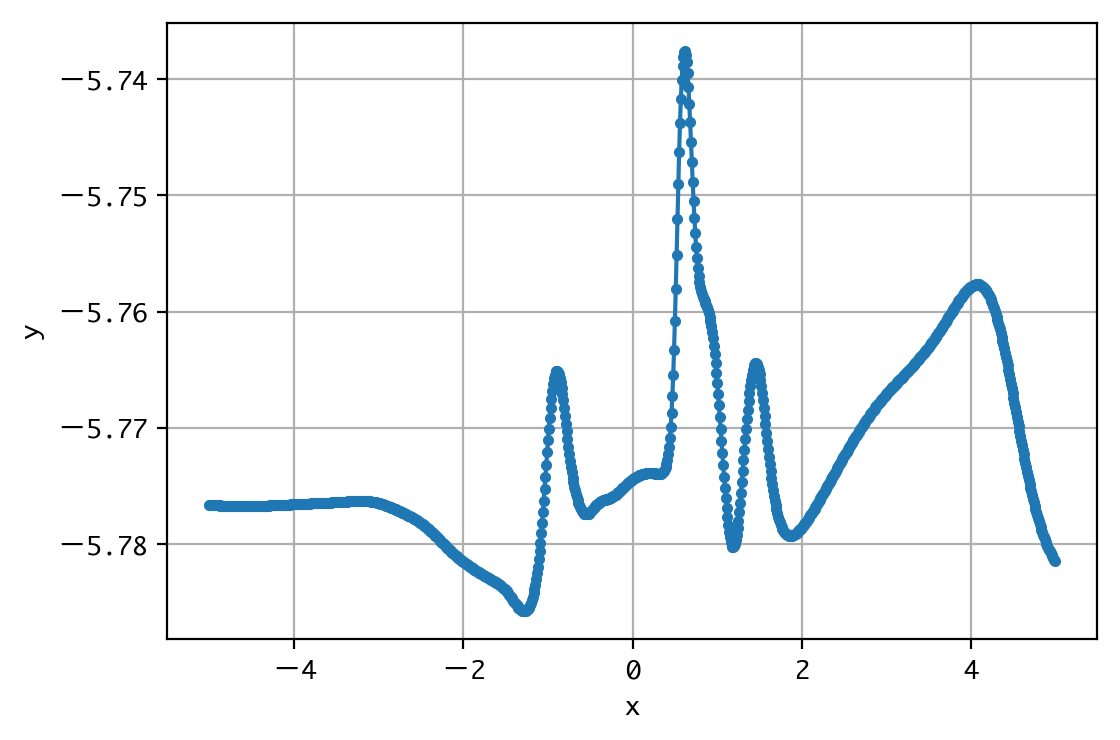

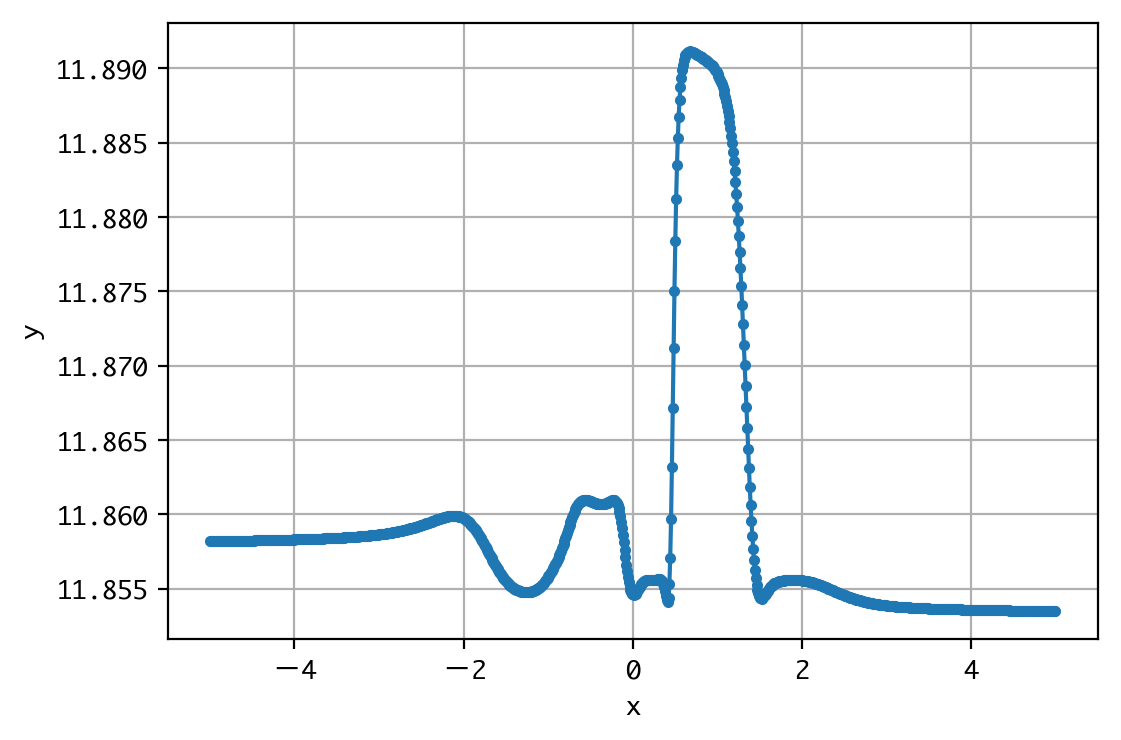

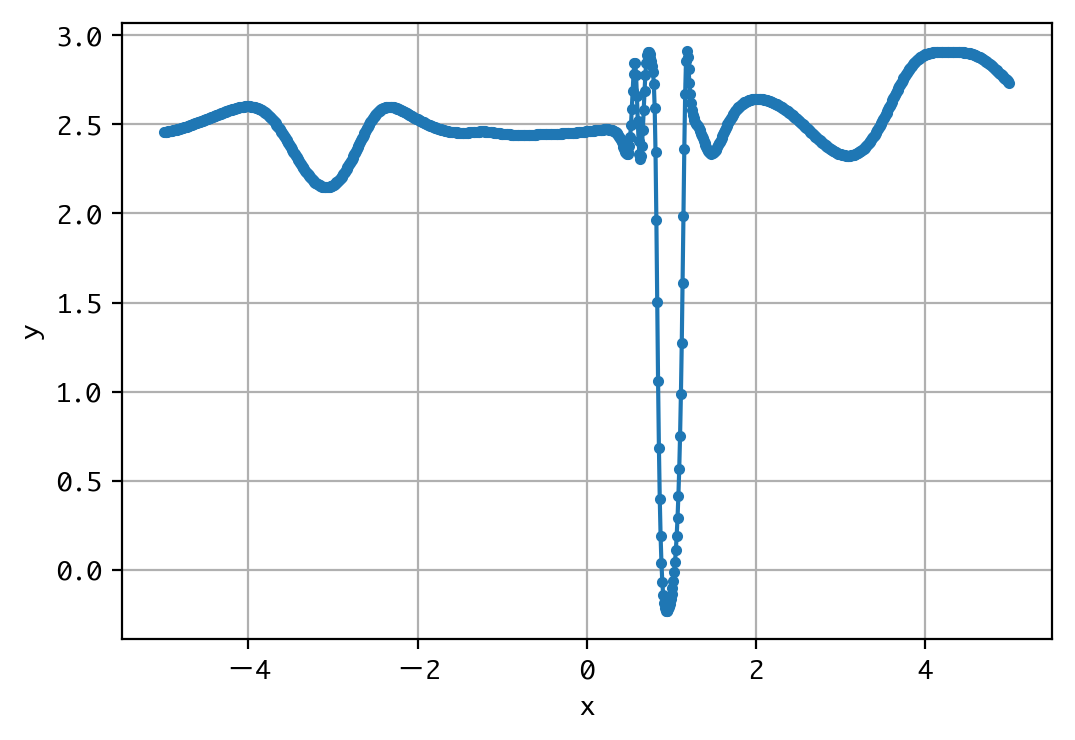

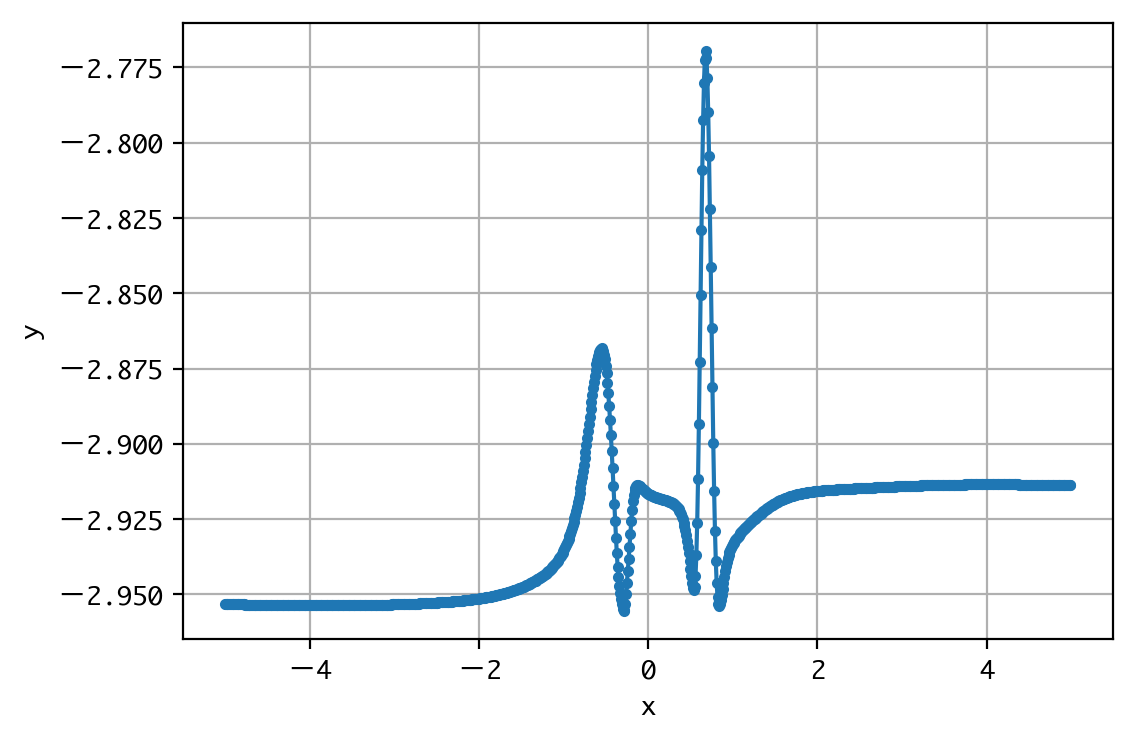

In [9]:
# 実験2
for seed in range(10):
    np_random = np.random.RandomState(seed)
    n2 = Network(np_random)
    n2.add(16, input_dim=1, activation='sigmoid')  # 1
    n2.add(16, activation='sigmoid')  # 2
    n2.add(16, activation='sigmoid')  # 3
    n2.add(16, activation='sigmoid')  # 4
    n2.add(16, activation='sigmoid')  # 5
    n2.add(16, activation='sigmoid')  # 6
    n2.add(16, activation='sigmoid')  # 7
    n2.add(16, activation='sigmoid')  # 8
    n2.add(16, activation='sigmoid')  # 9
    n2.add(16, activation='sigmoid')  # 10
    n2.add(16, activation='sigmoid')  # 11
    n2.add(16, activation='sigmoid')  # 12
    n2.add(16, activation='sigmoid')  # 13
    n2.add(16, activation='sigmoid')  # 14
    n2.add(16, activation='sigmoid')  # 15
    n2.add(16, activation='sigmoid')  # 16, 16*16=256
    n2.add(1)
    ys2 = [n2.forward(x) for x in xs]
    visualize(xs, ys2)

不気味なグラフが10個描画できました。

### ジャッジ

定性的な判断となってしまいますが、１のネットワークよりも、２のネットワークのほうが、表現力が豊かなように思います。

表現力の違いを生み出す要因としては、１よりも２のほうが重み（つまりパラメータ）の数が多いことが一因と考えられます。１の重みの数は512、２の重みの数は3616（16 + 14 * 256 + 16）です。ネットワークを作成した人間の言うことですので、計算については間違いないと思います。あるいは、図のイメージで言えば、後者のネットワークは、矢印の密集っぷりが半端ないということです。

そのパラメータの多さが、ネットワークに表現力を与えているのでしょう。もちろん適切にパラメータをチューニングできなければ、ただの抽象画で終わってしまうわけですが…。

### ３）重みの数が１と同程度のネットワーク

検証のため、重みの数が１と同程度（510）のネットワークを作成し、描画してみます。

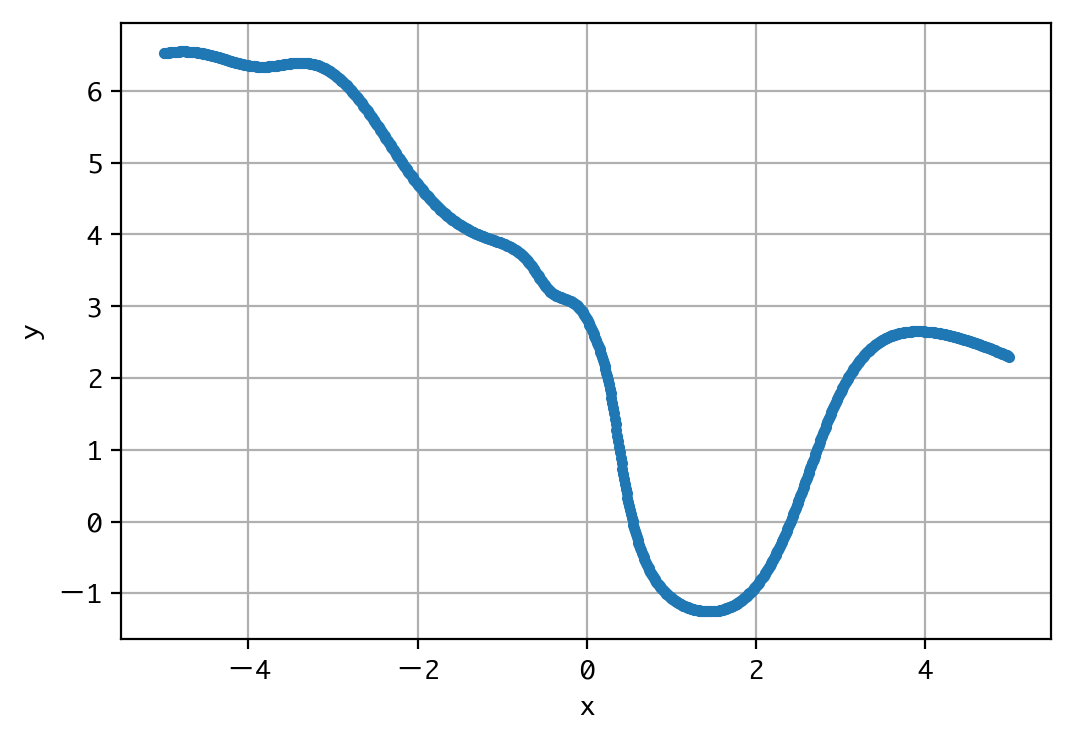

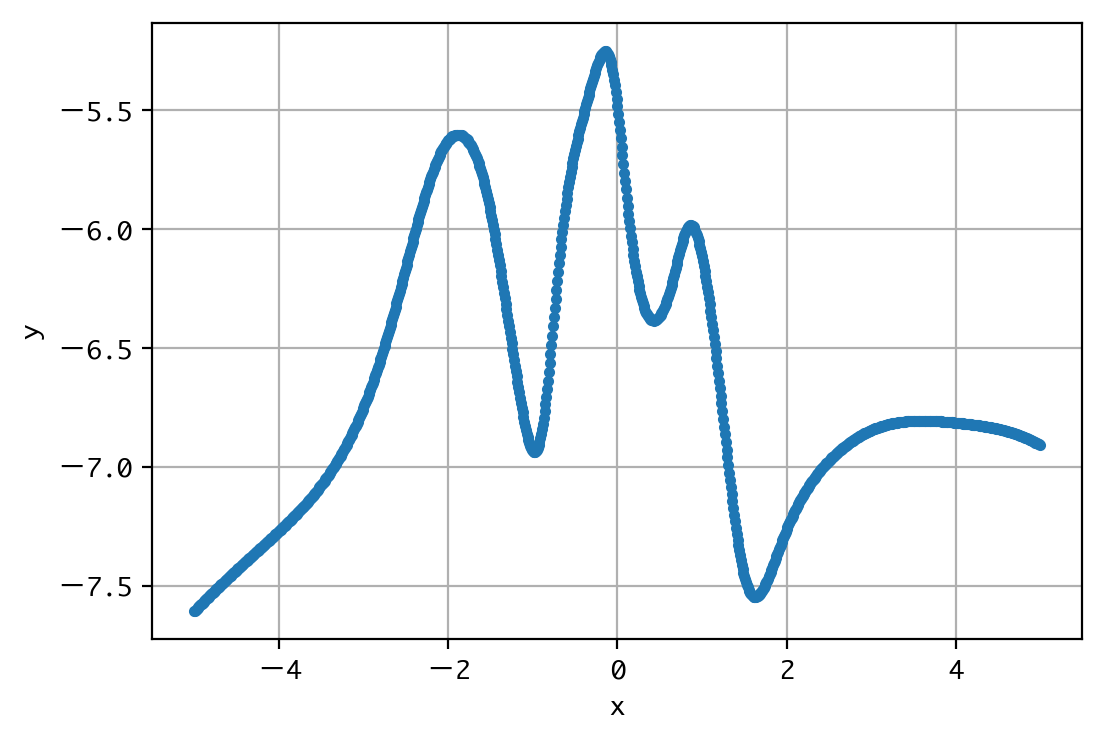

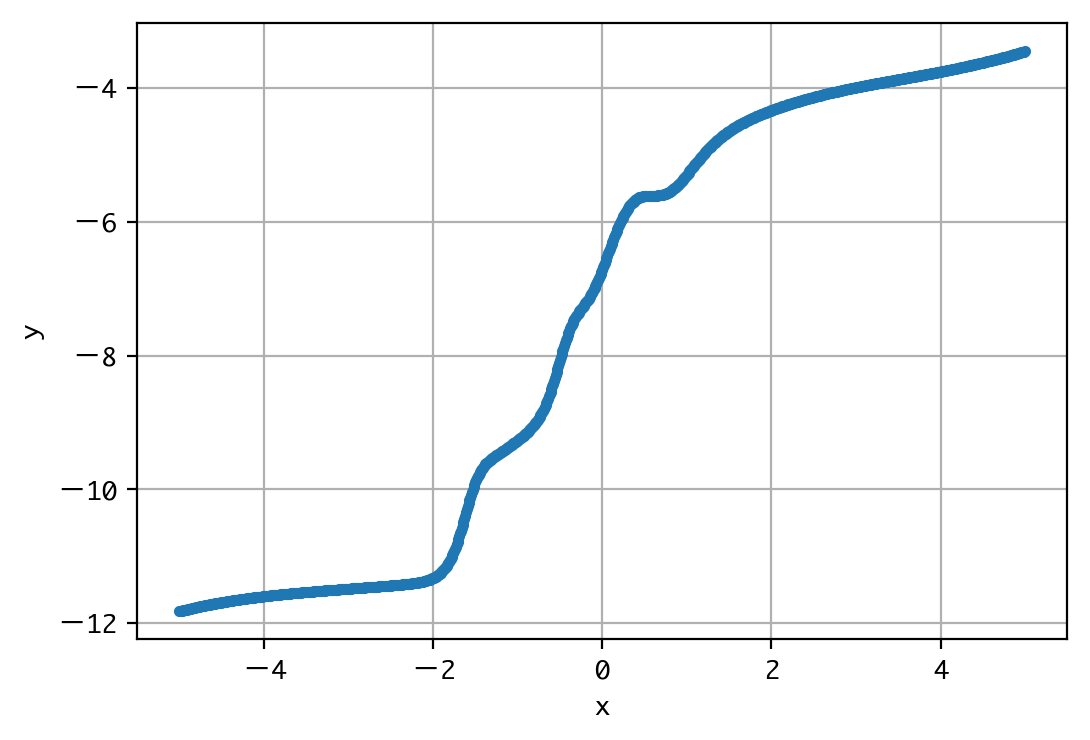

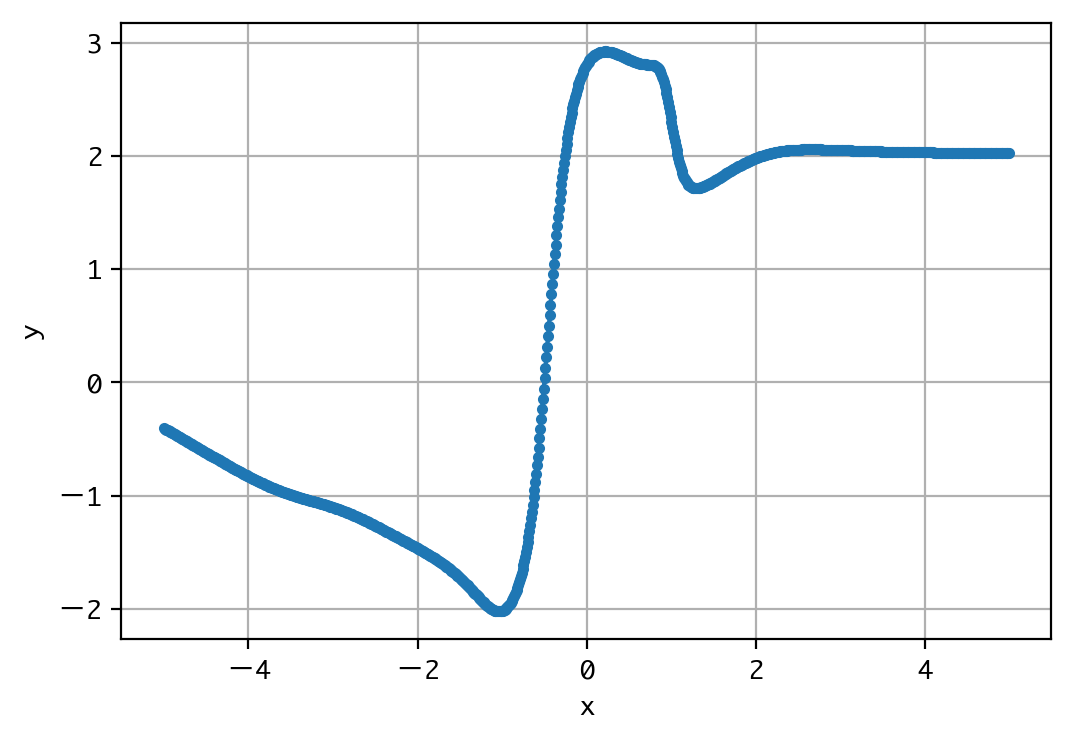

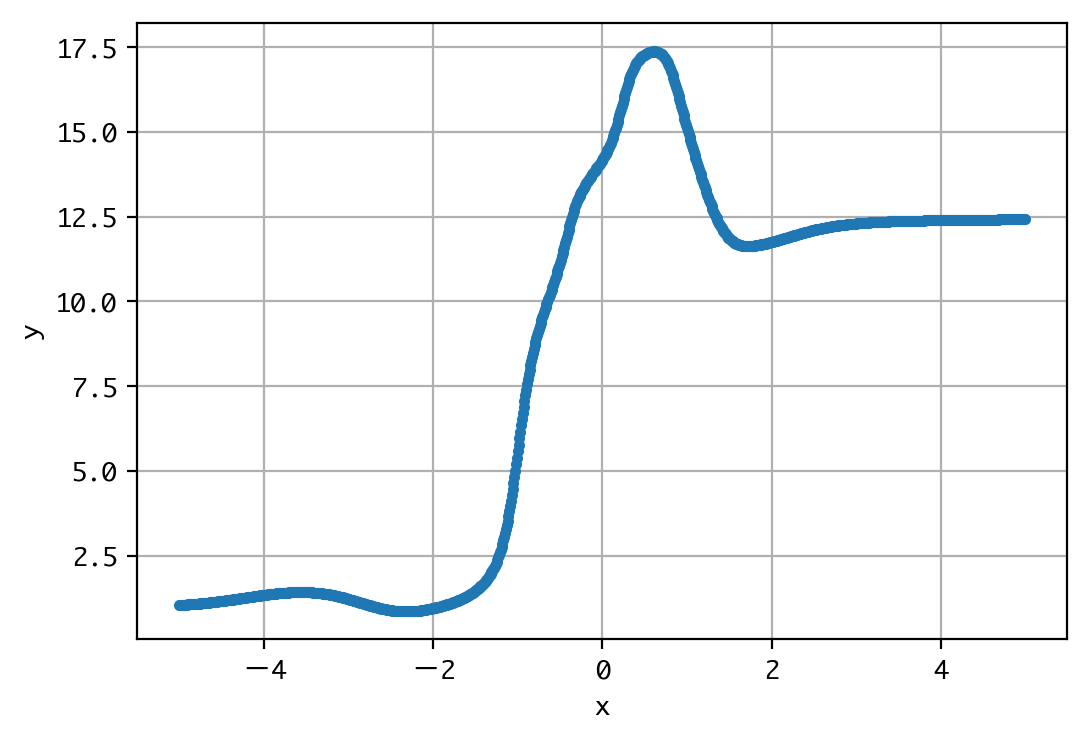

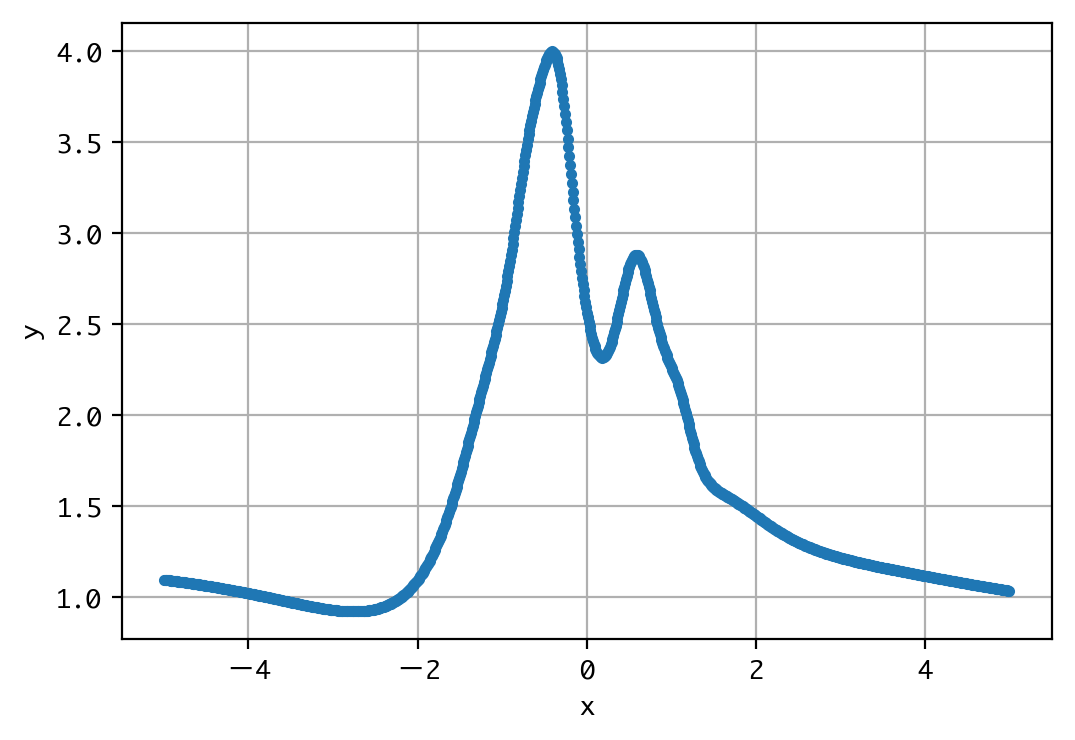

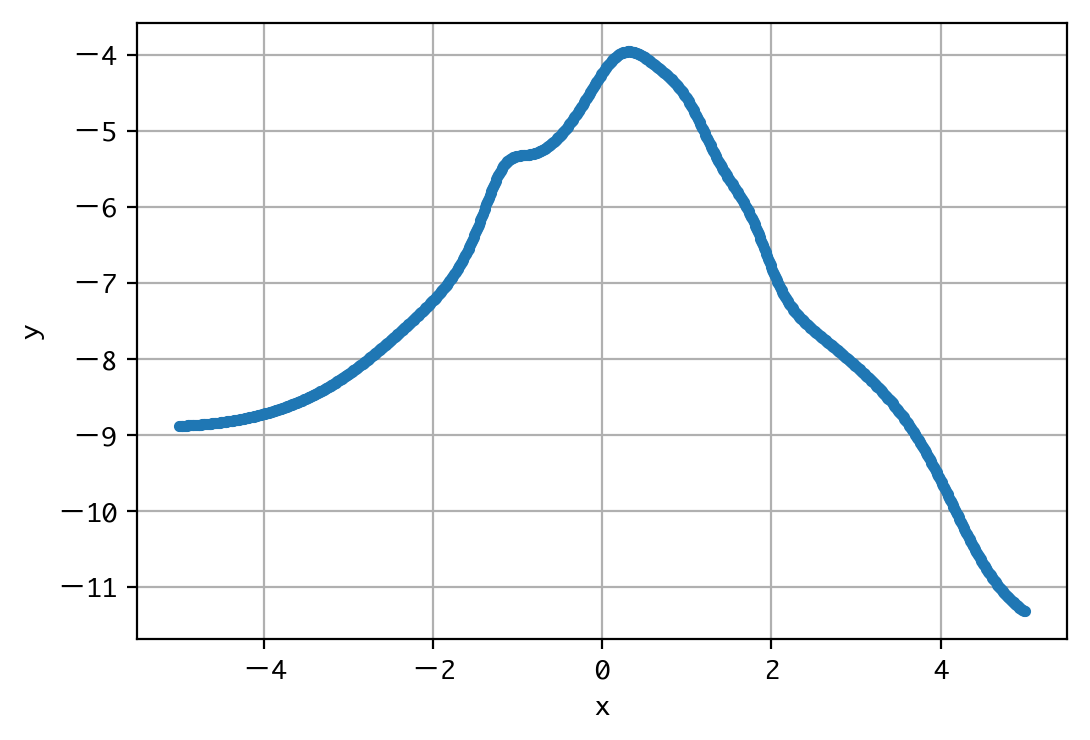

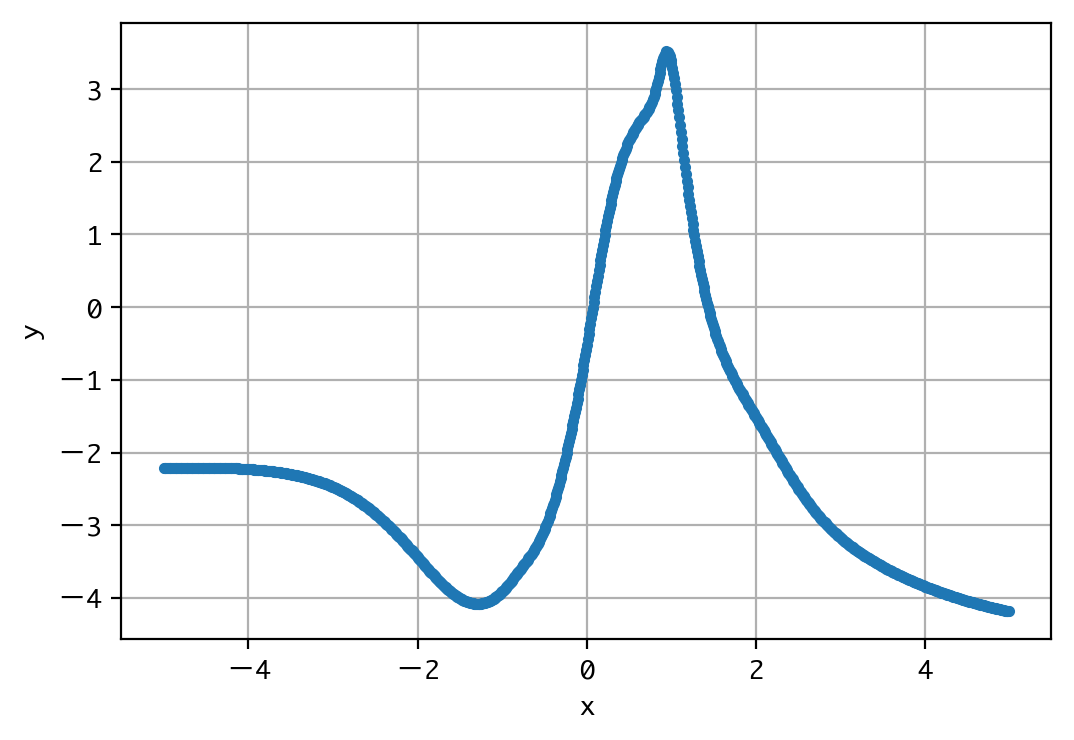

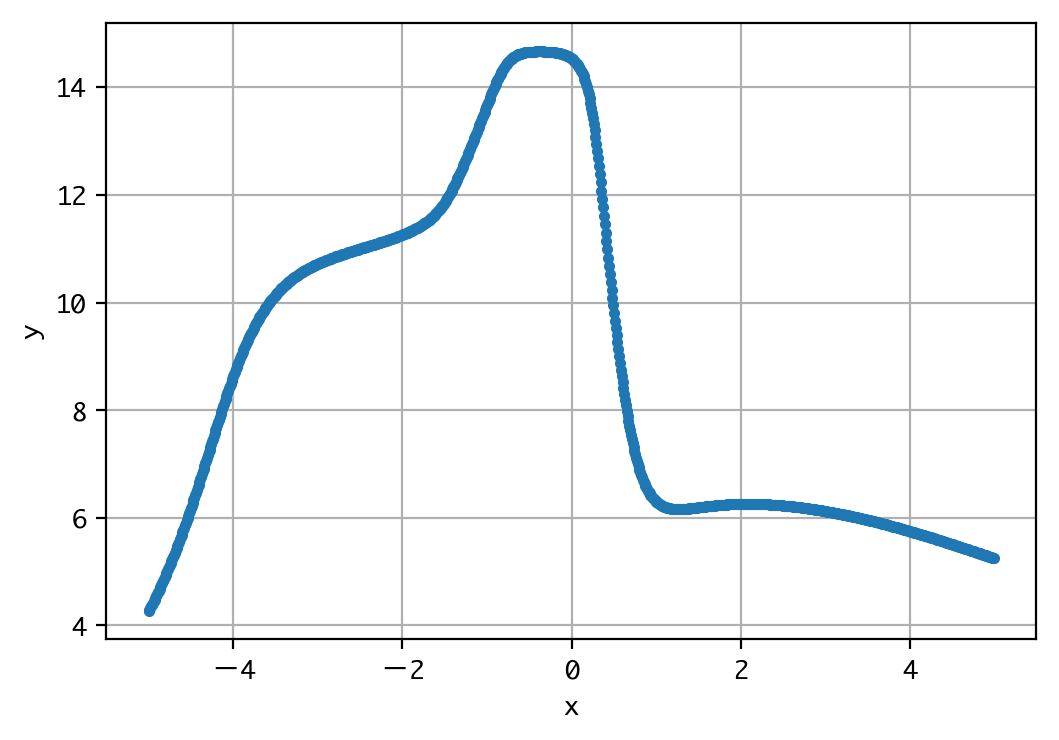

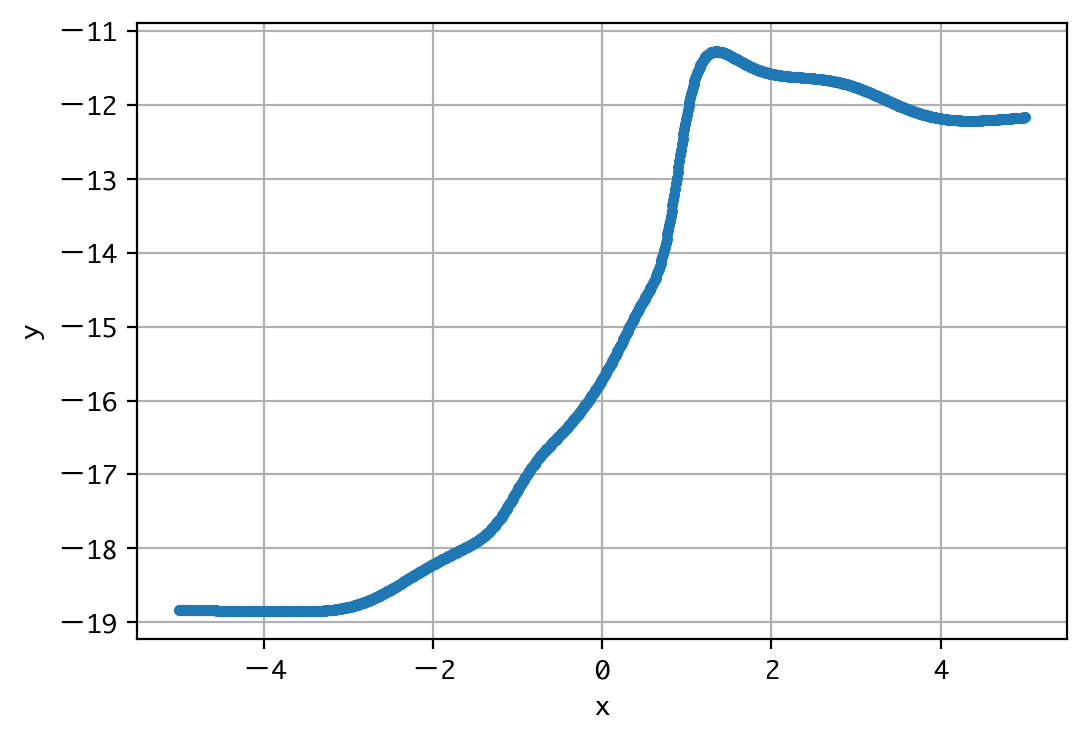

In [10]:
# 実験3
for seed in range(10):
    np_random = np.random.RandomState(seed)
    n3 = Network(np_random)
    n3.add(15, input_dim=1, activation='sigmoid')
    n3.add(16, activation='sigmoid')
    n3.add(15, activation='sigmoid')
    n3.add(1)
    ys3 = [n3.forward(x) for x in xs]
    visualize(xs, ys3)

定性的な判断となってしまいますが、１の表現力に近づいた気がします。

## 結論

畳み込みではない、層間が全結合の順伝播型ニューラルネットワークにおいて、層を深く（ディープに）することには、パラメータの数を増やし、ネットワークの表現力を増やす意味がある。ただし、適切なチューニングを行えなければ、表現力を持て余して意味がない。

## 余談

逆に、層を深くしすぎて、表現力を失うということもあります。

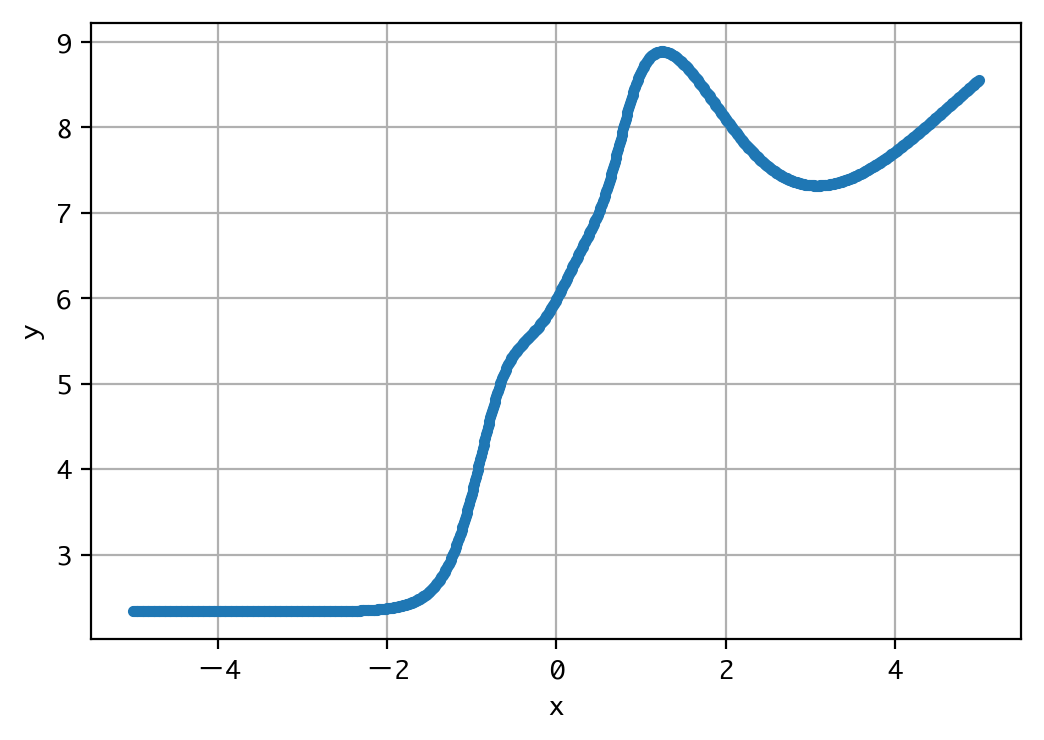

In [11]:
# 実験4
np_random = np.random.RandomState(seed)
n4 = Network(np_random)
n4.add(10, input_dim=1, activation='sigmoid')
for i in range(1):
    n4.add(10, activation='sigmoid')
n4.add(1)
ys4 = [n4.forward(x) for x in xs]
visualize(xs, ys4)

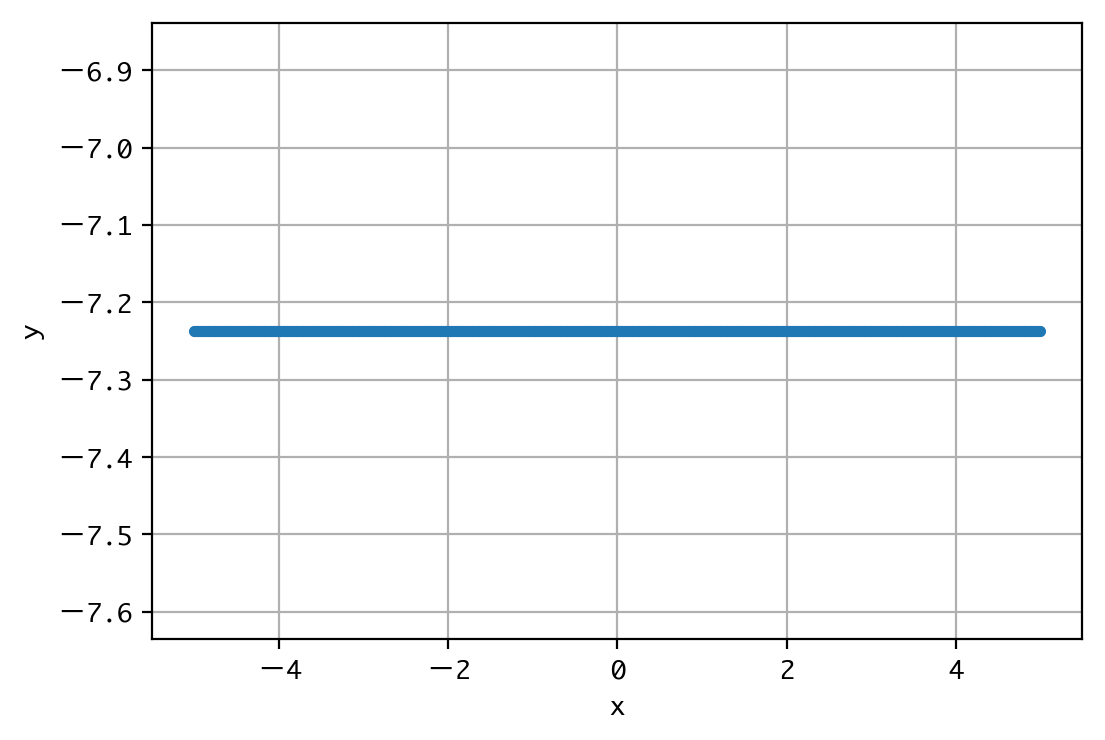

In [12]:
# 実験5
np_random = np.random.RandomState(seed)
n5 = Network(np_random)
n5.add(10, input_dim=1, activation='sigmoid')
for i in range(100):
    n5.add(10, activation='sigmoid')
n5.add(1)
ys5 = [n5.forward(x) for x in xs]
visualize(xs, ys5)

これは、シグモイド関数の適用を重ねることで、[不動点](https://ja.wikipedia.org/wiki/%E4%B8%8D%E5%8B%95%E7%82%B9)（の定数倍）へと収束してしまったものと思われます。

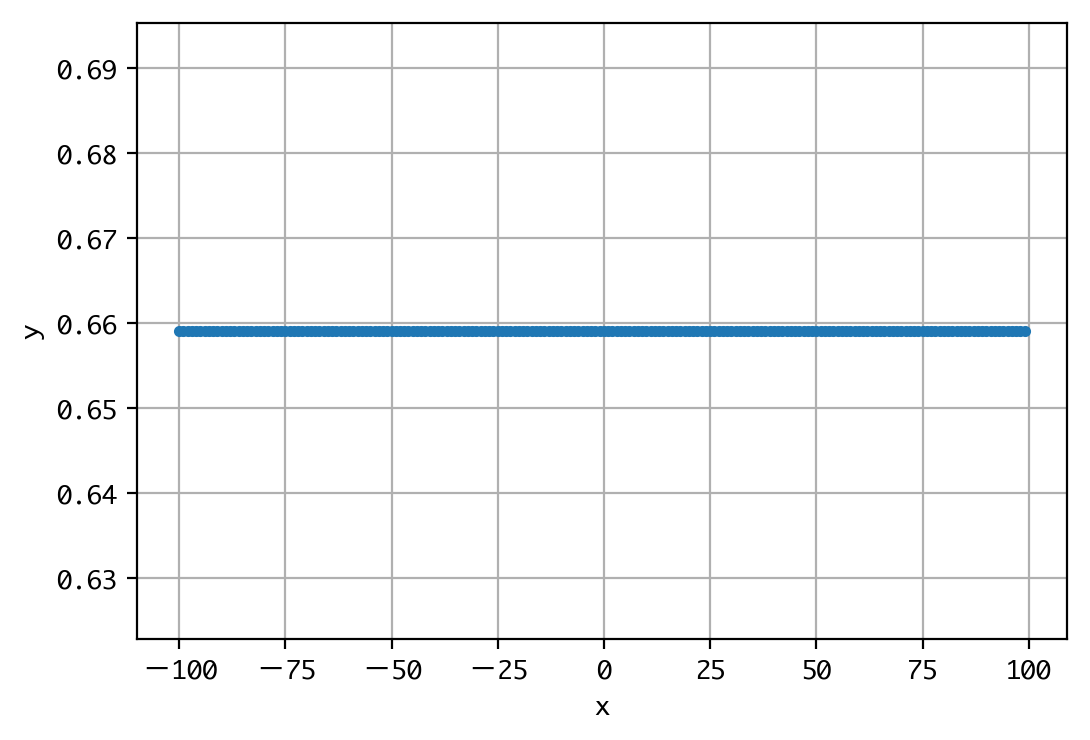

sigmoid(0.6590460684074066) = 0.6590460684074066


In [13]:
xs6 = np.arange(-100, 100)
ys6 = np.copy(xs6)
for i in range(30):
    ys6 = B.sigmoid(ys6)
visualize(xs6, ys6)
print('sigmoid(0.6590460684074066) =', B.sigmoid(0.6590460684074066))

層を深くすれば、パラメータも膨大になるし、結局のところ、適度なバランスが必要といったところでしょうね。なんと、ありふれた結論…。